In [1]:
from PyPDF2 import PdfFileReader
from wand.image import Image
import fitz

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

import os
import easyocr
import pytesseract
import cv2
import pandas as pd
import time

In [6]:
# Input PDF file path
pdf_file_path = '1098C_Samples/Sample 6_1098 C.pdf'

# Output image file path
output_image_path = 'Sample 6_1098 C.png'

# Create a PyMuPDF document and load the PDF
pdf_document = fitz.open(pdf_file_path)

# Render the first page as an image with high quality (DPI)
dpi = 300  # You can adjust the DPI as needed
first_page = pdf_document.load_page(0)
pix = first_page.get_pixmap(matrix=fitz.Matrix(dpi/72, dpi/72))

# Save the image with high quality
pix.save(output_image_path)

# Close the PDF document
pdf_document.close()

print(f'Conversion of the first page to {output_image_path} completed.')

Conversion of the first page to Sample 6_1098 C.png completed.


In [7]:
def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

def find_squares(img, threshold):
    img = cv.GaussianBlur(img, (5, 5), 0)
    squares = []
    for gray in cv.split(img):
        for thrs in range(0, 255, 26):
            if thrs == 0:
                bin = cv.Canny(gray, 0, 50, apertureSize=5)
                bin = cv.dilate(bin, None)
            else:
                _retval, bin = cv.threshold(gray, thrs, 255, cv.THRESH_BINARY)
            contours, _hierarchy = cv.findContours(bin, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt_len = cv.arcLength(cnt, True)
                cnt = cv.approxPolyDP(cnt, 0.02*cnt_len, True)
                if len(cnt) == 4 and cv.contourArea(cnt) > 5000 and cv.isContourConvex(cnt):
                    cnt = cnt.reshape(-1, 2)
                    max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
                    if max_cos < threshold:
                        squares.append(cnt)
    return squares

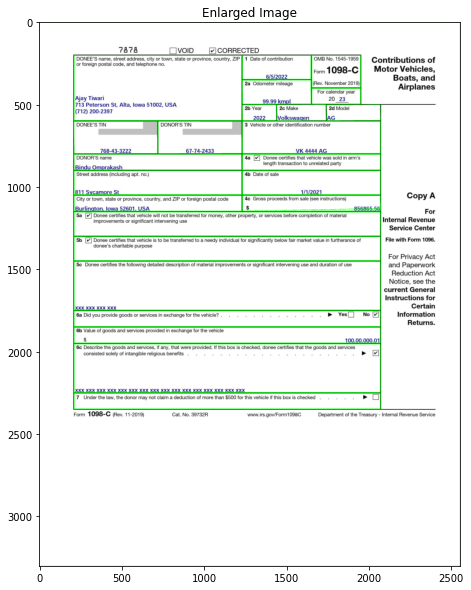

In [8]:
image = cv2.imread('Sample 6_1098 C.png')
image_dis = cv2.imread('Sample 6_1098 C.png')

squares = find_squares(image, 0.1)
cv2.drawContours(image_dis, squares, -1, (0, 255, 0), 1)

# Create a larger figure size
plt.figure(figsize=(15, 10))  # Adjust the width and height as needed

# Show the image using Matplotlib
plt.imshow(cv2.cvtColor(image_dis, cv2.COLOR_BGR2RGB))

# Add a title (optional)
plt.title("Enlarged Image")

# Display the image
plt.show()

In [9]:
len(squares)

603

Centroid Coordinates: (464, 700)
Centroid Coordinates: (719, 399)
Centroid Coordinates: (719, 849)
Centroid Coordinates: (719, 974)
Centroid Coordinates: (719, 1099)
Centroid Coordinates: (973, 699)
Centroid Coordinates: (1139, 1224)
Centroid Coordinates: (1139, 1374)
Centroid Coordinates: (1139, 1599)
Centroid Coordinates: (1139, 1799)
Centroid Coordinates: (1139, 2099)
Centroid Coordinates: (1139, 2299)
Centroid Coordinates: (1274, 1649)
Centroid Coordinates: (1335, 549)
Centroid Coordinates: (1439, 274)
Centroid Coordinates: (1439, 424)
Centroid Coordinates: (1589, 549)
Centroid Coordinates: (1642, 1097)
Centroid Coordinates: (1649, 699)
Centroid Coordinates: (1649, 849)
Centroid Coordinates: (1649, 974)
Centroid Coordinates: (1799, 299)
Centroid Coordinates: (1799, 449)
Centroid Coordinates: (1904, 549)


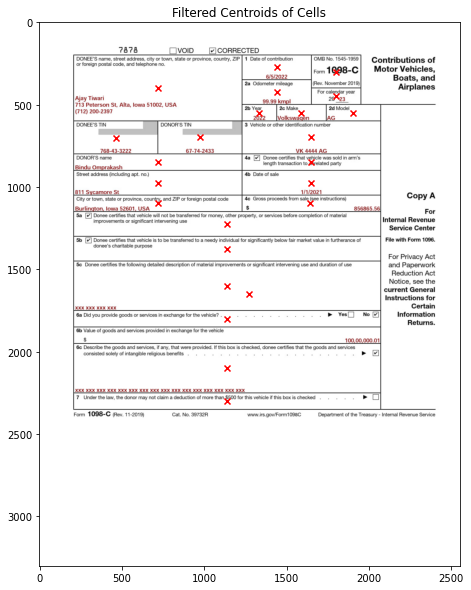

In [10]:
# Calculate the centroids of the squares
centroids = []
for square in squares:
    M = cv.moments(square)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append((cX, cY))
        
centroids = list(set(centroids))

# Function to check if two centroids are close to each other
def are_close(centroid1, centroid2, threshold=100):
    return abs(centroid1[0] - centroid2[0]) <= threshold and abs(centroid1[1] - centroid2[1]) <= threshold

# Remove duplicate centroids (within a threshold) while preserving order
filtered_centroids = [centroids[0]]
for i in range(1, len(centroids)):
    is_duplicate = False
    for j in range(len(filtered_centroids)):
        if are_close(centroids[i], filtered_centroids[j]):
            is_duplicate = True
            break
    if not is_duplicate:
        filtered_centroids.append(centroids[i])

# Sort the filtered centroids by X and Y coordinates
filtered_centroids.sort(key=lambda x: (x[0], x[1]))

# Create a larger figure size
plt.figure(figsize=(15, 10))

# Plot the filtered centroids as red points and print their coordinates
for cX, cY in filtered_centroids:
    plt.scatter(cX, cY, marker='x', c='r')
    print(f"Centroid Coordinates: ({cX}, {cY})")

plt.imshow(image)
plt.title("Filtered Centroids of Cells")
plt.show()

In [11]:
len(filtered_centroids)

24

Group 1 - Number of Squares: 15
Group 2 - Number of Squares: 27
Group 3 - Number of Squares: 24
Group 4 - Number of Squares: 28
Group 5 - Number of Squares: 26
Group 6 - Number of Squares: 15
Group 7 - Number of Squares: 29
Group 8 - Number of Squares: 27
Group 9 - Number of Squares: 27
Group 10 - Number of Squares: 54
Group 11 - Number of Squares: 27
Group 12 - Number of Squares: 27
Group 13 - Number of Squares: 27
Group 14 - Number of Squares: 21
Group 15 - Number of Squares: 25
Group 16 - Number of Squares: 23
Group 17 - Number of Squares: 3
Group 18 - Number of Squares: 27
Group 19 - Number of Squares: 27
Group 20 - Number of Squares: 27
Group 21 - Number of Squares: 27
Group 22 - Number of Squares: 27
Group 23 - Number of Squares: 27
Group 24 - Number of Squares: 16


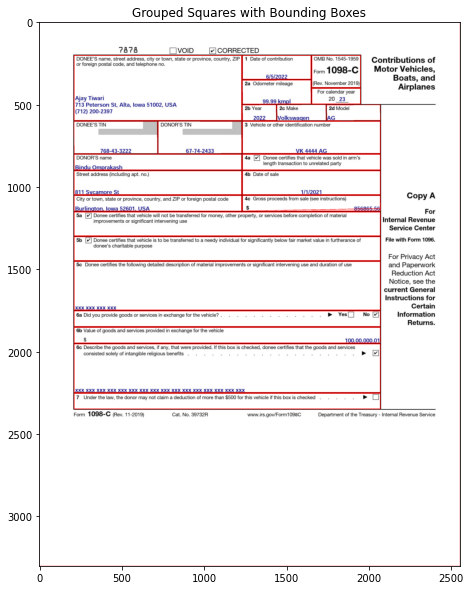

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



# Initialize a list of empty lists to represent grouped squares
grouped_squares = [[] for _ in filtered_centroids]

# Function to calculate the distance between two points (centroids and square centroids)
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Group squares based on the closest centroid
for square in squares:
    square_centroid = (
        int((square[0][0] + square[1][0] + square[2][0] + square[3][0]) / 4),
        int((square[0][1] + square[1][1] + square[2][1] + square[3][1]) / 4)
    )
    
    # Find the closest centroid for this square's centroid
    closest_centroid_idx = min(
        range(len(filtered_centroids)),
        key=lambda i: calculate_distance(square_centroid, filtered_centroids[i])
    )
    
    # Add the square to the corresponding group
    grouped_squares[closest_centroid_idx].append(square)

# Create a larger figure size
plt.figure(figsize=(15, 10))

# Plot grouped squares with bounding boxes
for i, squares_in_group in enumerate(grouped_squares):
    group_color = (0, 0, 255)  # Generate a random color for each group
    for square in squares_in_group:
        cv2.drawContours(image_dis, [square], 0, group_color, 1)  # Draw bounding box
    print(f"Group {i + 1} - Number of Squares: {len(squares_in_group)}")

plt.imshow(cv2.cvtColor(image_dis, cv2.COLOR_BGR2RGB))
plt.title("Grouped Squares with Bounding Boxes")
plt.show()

In [13]:
len(grouped_squares)

24

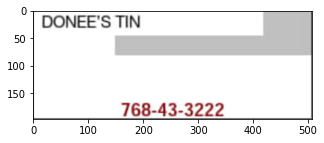

Processed Cell 0 - Centroid: (464, 700), Text: DONEE’S TIN

768-43-3222




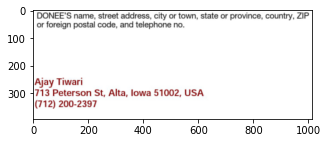

Processed Cell 1 - Centroid: (719, 399), Text: DONEE'S name, street address, city or town, state or province, country, ZIP
or foreign postal code, and telephone no.

Ajay Tiwari
713 Peterson St, Alta, lowa 51002, USA
(712) 200-2397



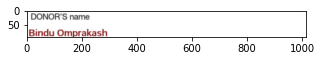

Processed Cell 2 - Centroid: (719, 849), Text: DONOR'S name
Bindu Omprakash



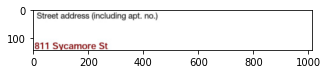

Processed Cell 3 - Centroid: (719, 974), Text: Street address (including apt. no.)

811 Svcamore St



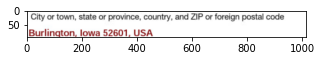

Processed Cell 4 - Centroid: (719, 1099), Text: City or town, state or province, country, and ZIP or foreign postal code
Burlinaton, lowa 52601, USA



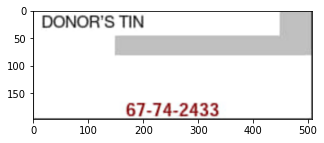

Processed Cell 5 - Centroid: (973, 699), Text: DONOR'S TIN

67-74-2433




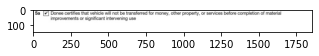

Processed Cell 6 - Centroid: (1139, 1224), Text: 5a Donee certifies that vehicle will not be transferred for money, other property, or services before completion of material
improvements or significant intervening use



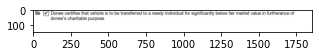

Processed Cell 7 - Centroid: (1139, 1374), Text: 5b Donee certifies that vehicle is to be transferred to a needy individual for significantly below fair market value in furtherance of
donee’s charitable purpose



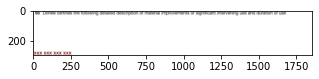

Processed Cell 8 - Centroid: (1139, 1599), Text: 5c Donee certifies the following detailed description of material improvements or significant intervening use and duration of use

MXK XXK XXX XXX



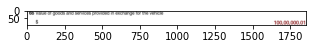

Processed Cell 9 - Centroid: (1139, 1799), Text: 6b Value of goods and services provided in exchange for the vehicle
$ 100,00,000.01



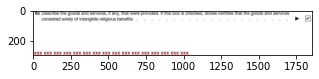

Processed Cell 10 - Centroid: (1139, 2099), Text: 6c Describe the goods and services, if any, that were provided. If this box is checked, donee certifies that the goods and services
consisted solely of intangible religious benefits ©. 2. 2... ke

xxXX XXK XXX XXK XKXK XXX XKK KKK XKXK KKK KXXK XKK XXX XKXK KKK XXX



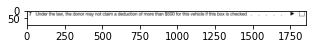

Processed Cell 11 - Centroid: (1139, 2299), Text: 7 Under the law, the donor may not claim a deduction of more than $500 for this vehicle if this box is checked



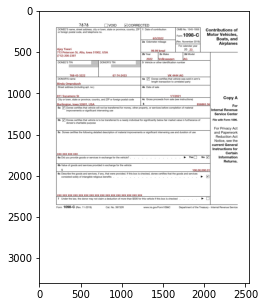

Processed Cell 12 - Centroid: (1274, 1649), Text: ta-Wa-) [ ]VOID [v¥] CORRECTED
DONEE'S name, street address, city or town, state or province, country, ZIP | 1 Date of contribution OMB No. 1545-1959 Contributions of

or foreign postal code, and telephone no. .
rom 1098-C Motor Vehicles,
6/5/2022 Boats, and

2a Odomet il ev. November 2019) .
=— - : Airplanes
For calendar year
Ajay Tiwari 20 23
713 Peterson St, Alta, lowa 51002, USA 2b Year — rae ids 2d Model
2022 Volkswagen AG
DONEE'’S TIN DONOR'S TIN 3 Vehicle or other identification number
768-43-3222 67-74-2433 VK 4444 AG

DONOR'S name da Donee certifies that vehicle was sold in arm's

Nauk teriieakaah length transaction to unrelated party

Street address (including apt. no.) 4b Date of sale

811 Sycamore St 1/1/2021 Copy A

City or town, state or province, country, and ZIP or foreign postal code 4c Gross proceeds from sale (see instructions)
Burlington, lowa 52601, USA $ 856865.56 For

5a Donee certifies that vehicle will not be tr

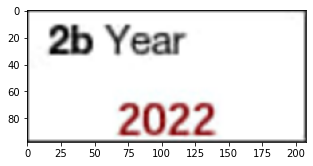

Processed Cell 13 - Centroid: (1335, 549), Text: 2b Year
2022




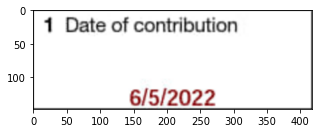

Processed Cell 14 - Centroid: (1439, 274), Text: 1 Date of contribution

6/5/2022




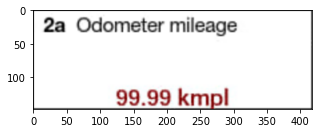

Processed Cell 15 - Centroid: (1439, 424), Text: 2a Odometer mileage

99.99 kmpl




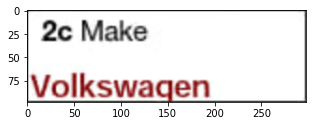

Processed Cell 16 - Centroid: (1589, 549), Text: 2c Make

Volkswagen




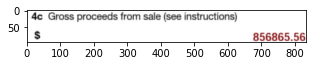

Processed Cell 17 - Centroid: (1642, 1097), Text: 4c Gross proceeds from sale (see instructions)
$ 856865.56



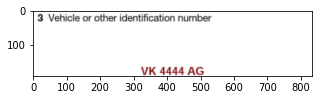

Processed Cell 18 - Centroid: (1649, 699), Text: 3 Vehicle or other identification number

VK 4444 AG



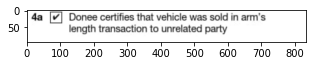

Processed Cell 19 - Centroid: (1649, 849), Text: 4a Donee certifies that vehicle was sold in arm's
length transaction to unrelated party



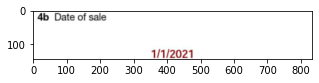

Processed Cell 20 - Centroid: (1649, 974), Text: 4b Date of sale

1/1/2021



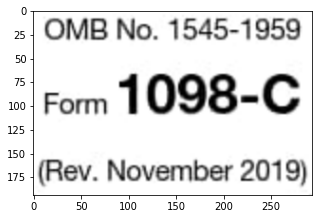

Processed Cell 21 - Centroid: (1799, 299), Text: OMB No. 1545-1959

Form 1 098-C

(Rev. November 2019)



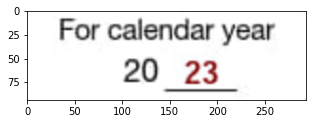

Processed Cell 22 - Centroid: (1799, 449), Text: For calendar year
20 23



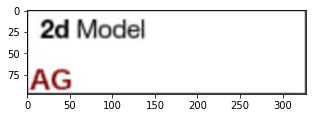

Processed Cell 23 - Centroid: (1904, 549), Text: 2d Model
AG


Text extraction completed.
Elapsed Time: 29.74945569038391


In [15]:
import os
start_time = time.time()

data = []

final_contours = []
aved_images = set()

# Iterate through each group of squares
for i, squares_in_group in enumerate(grouped_squares):
    if len(squares_in_group) > 0:
        # Select one square from the group (e.g., the first one)
        square = squares_in_group[0]
        
        # Get the coordinates of the square's bounding box
        x, y, w, h = cv2.boundingRect(square)
        
        # Append the bounding box coordinates as a tuple (x, y, w, h) to final_contours
        final_contours.append((x, y, w, h))
        
        # Crop the image based on the bounding box
        cropped_image = image[y:y+h, x:x+w]
    
    
        # Extract text from the cell image using pytesseract
        text = pytesseract.image_to_string(cropped_image, lang='eng')

        # Append the cell number and text to the data list
        data.append(text)


        #Optional: Display the image with its centroid for verification
        plt.figure(figsize=(5, 5))
        plt.imshow(cropped_image)
        plt.show()

        # Print the processed centroid and image path for verification
        print(f"Processed Cell {i} - Centroid: {filtered_centroids[i]}, Text: {text}")

print("Text extraction completed.")
end_time = time.time()
print(f"Elapsed Time: {end_time - start_time}")